In [1]:
from math import ceil

from os.path import join
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## How to use this notebook

**Input**: Contig summary statistics table(s) `ctg_stats.csv` generated by the rule `concat_statistics` and contig length table(s) `ctg_lens.csv` generated by the rule `concat_lengths`. 

**Output**: 

1) Grouped bar graph(s) of the number of contigs, bases, and mean contig length made be each *de novo* assembler grouped by sample. 

2) Violin plots of all contigs lengths for each *de novo* assembler grouped by sample. 

### Steps

**Usage**: There is one cells that require user customization, described below. I designed this notebook specifically for the test dataset but tried to generalize as much as possible. The cell is indicated with the text `Customize here`. 

1) Add paths to the contig summary statistics tables you want to visualize to `stats_lst`.

- More summary tables can be added if you want to aggregate reports from several runs!

2) Customize how the samples are named and grouped using `samples_ordered` and `samples_labeled`. 

3) Customize the number of assemblers used using `assembs_labeled`.

4) Customize the number of bar colours according to the number of steps used in the quality control process using `sample_asm_colours`. 

## Load sample tables

### Contig summary statistics tables

In [2]:
# Set seaborn plotting aesthetics as default
sns.set()

In [31]:
# Customize here
# Add contig summary statistics tables for each sample set to a list
stats_lst = ['test_data/test_out/short-read-assembly/final_reports/ctg_stats.csv']
lens_lst = ['test_data/test_out/short-read-assembly/final_reports/ctg_lens.csv']
out_dir = 'test_data/dataviz'

# If applicable, rename the samples in the table and/or set display names
samples_ordered = ['uhgg']
samples_labeled = ['UHGG'] # Optional- can also be merged_df['sample_name']

# If applicable (i.e.: used more than one assembler), set display names of the assemblers
# If not applicable (i.e.: only used one), leave the list empty
assembs_labeled = ['MetaSPAdes', 'Megahit']

# The number of colour lists is equal to the number of samples, and the number
# of colours in each list is equal to the number of assemblers used on the sample.
# Here, I have 1 colour per list because I'm only using metaSPAdes.
# If you used both metaSPAdes and Megahit, add the second colour to the list. 
sample_asm_colours = ['#ffa600', '#ffD832']
#                    ['#ff6361'], #ff9593
#                    ['#bc5090'], #ee82C2
#                    ['#58508d']] #8a82bf
#                    ['#003F5C']] #32718E

In [6]:
# Merge the sample set dataframes and check their contents
df_lst = []
for df in stats_lst:
    df_lst.append(pd.read_csv(df, header = 0))
stats_df = pd.concat(df_lst)

stats_df

,sample_name,assembler,num_ctgs,total_size,mean_ctg_len
0,uhgg,0_metaspades,5930,16329165,2753.65
1,uhgg,1_megahit,5220,15964943,3058.42


### Contig length tables

In [7]:
# Merge the sample set contig length dataframes and check their contents
df_lst = []
for df in lens_lst:
    df_lst.append(pd.read_csv(df, header = 0))
lengths_df = pd.concat(df_lst)

lengths_df.iloc[[1,500,1000],:] 

,sample_name,assembler,ctg_size
1,uhgg,0_metaspades,28207
500,uhgg,0_metaspades,6694
1000,uhgg,0_metaspades,4825


### Count the number of contigs and bases kept with each minimum threshold

In [8]:
for i,s in enumerate(samples_ordered):
    tmp_df = lengths_df[lengths_df['sample_name'] == s]
    num_ctgs = tmp_df.shape[0]
    asm_size = tmp_df['ctg_size'].sum()
    for n in [0, 1000, 2500, 10000, 20000, 50000, 100000, 500000]:
        larger_df = tmp_df[tmp_df['ctg_size'] >= n]
        num_larger = larger_df.shape[0]
        asm_larger = larger_df['ctg_size'].sum()
        print('{0} >{1} bp: {2} ({3:.3f}), {4} ({5:.3f})'.
              format(samples_labeled[i], n, num_larger, num_larger / num_ctgs, 
                     asm_larger, asm_larger / asm_size))

UHGG >0 bp: 11150 (1.000), 32294108 (1.000)
UHGG >1000 bp: 8254 (0.740), 30600748 (0.948)
UHGG >2500 bp: 4683 (0.420), 24630118 (0.763)
UHGG >10000 bp: 296 (0.027), 3801602 (0.118)
UHGG >20000 bp: 5 (0.000), 122914 (0.004)
UHGG >50000 bp: 0 (0.000), 0 (0.000)
UHGG >100000 bp: 0 (0.000), 0 (0.000)
UHGG >500000 bp: 0 (0.000), 0 (0.000)


# Contig Summary Stats Dataviz

## Numbers of reads and bases for each sample's *de novo* assembly

In [32]:
def bar_plot(df, p, n, a):
    p = sns.barplot(data = df, x = 'sample_name', y = p, \
                    order = samples_ordered, palette = sample_asm_colours, ax = a) 
    p.set_xticklabels(samples_labeled, size = 16)
    p.set_xlabel(None)
    p.set_ylabel(n, size = 20)
    return p

In [33]:
%%capture
# To suppress figure output
# Define plotting region
# Rows:    1  
# Columns: 3. Row 1 graphs the numbers of reads. Row 2 graphs the number of bases.
col_labels = {'Num. Contigs'     : 'num_ctgs', 
              'Num. Bases'       : 'total_size', 
              'Mean Contig Size' : 'mean_ctg_len'}
fig, axs = plt.subplots(1, len(col_labels.keys()), figsize = (20,8)) # in.
fig.tight_layout(pad = 4)

In [34]:
for i, c in enumerate(col_labels):
    bar_plot(stats_df, col_labels[c], c, axs[i])

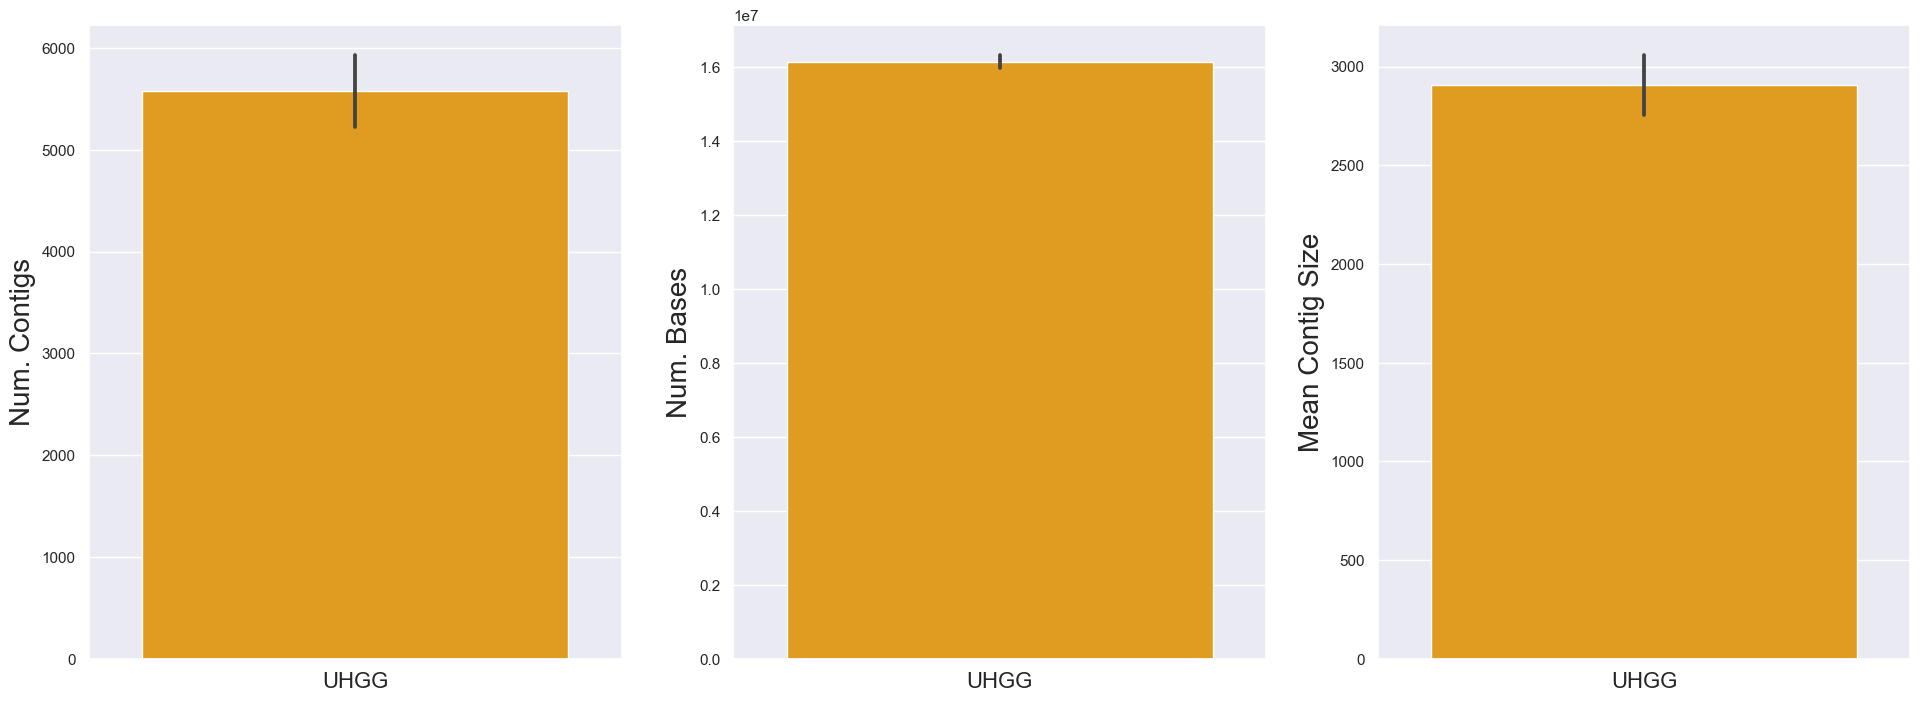

In [35]:
# If applicable, add a global legend and plot the graph
# if len(assembs_labeled) > 1: # If multiple assemblers are used
#     for i, r in enumerate(row_labels): 
#         a = axs[i,0] if i > 1 else axs[0]
#         handles, labels = axs[0].get_legend_handles_labels()
#         fig.legend(handles, assembs_labeled, loc = 'center right', fontsize = 16)
fig

In [36]:
# Save a large SVG without padding
fig.savefig(join(out_dir, 'num_ctgs_bases_avgs.png'), dpi = 1000, bbox_inches = 'tight')

## *De novo* assembled contig length distributions

In [20]:
def violin_plot(df, a):
    p = sns.violinplot(data = df, x = 'sample_name', y = 'ctg_size', \
                       order = samples_ordered, palette = sample_asm_colours, ax = a)
    p.set_xticklabels(samples_labeled, rotation = 45, ha = 'right') 
    p.set(xlabel = None) 
    p.set_ylabel('Contig Size (bp)', size = 16)
    return p

In [21]:
# Set a maximum so that meaningful differences can be seen on one of the plots
min_len = 1000
max_len = 10000
max_lengths_df = lengths_df[lengths_df['ctg_size'] >= min_len]
range_lengths_df = max_lengths_df[max_lengths_df['ctg_size'] <= max_len]
print('Num. ctgs shorter than {} bp in length: {}'.format(min_len, max_lengths_df.shape[0]))
print('Num. ctgs. between {} and {} bp in length: {}'.format(min_len, max_len, range_lengths_df.shape[0]))
print('Num. ctgs. longer than {} bp in length: {}'.format(max_len, lengths_df.shape[0] - range_lengths_df.shape[0] - max_lengths_df.shape[0]))
max_lengths_df.iloc[[1,500,1000],:] 

Num. ctgs shorter than 1000 bp in length: 8254
Num. ctgs. between 1000 and 10000 bp in length: 7958
Num. ctgs. longer than 10000 bp in length: -5062


,sample_name,assembler,ctg_size
2,uhgg,0_metaspades,25250
501,uhgg,0_metaspades,6686
1001,uhgg,0_metaspades,4825


In [37]:
%%capture
# To suppress figure output
# Define plotting region
# Rows:    1
# Columns: 3 for all lengths, minimum-thresholded, and maximum-thresholded 
fig, axs = plt.subplots(1, 2, figsize = (12,6)) # in.
fig.tight_layout(pad = 4)

In [38]:
violin_plot(lengths_df, axs[0])
# violin_plot(max_lengths_df, axs[1])
violin_plot(range_lengths_df, axs[1])

<AxesSubplot:ylabel='Contig Size (bp)'>

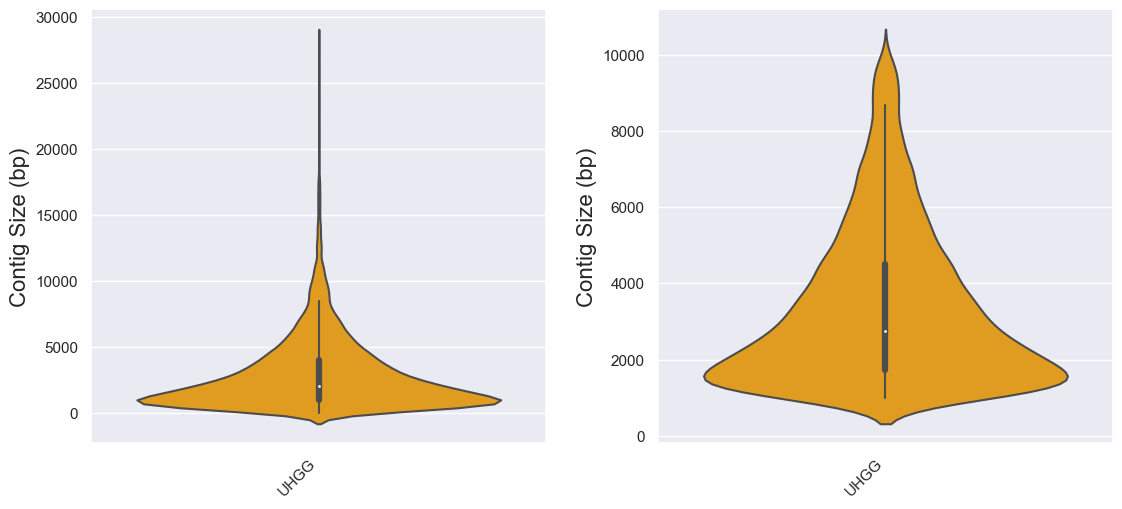

In [39]:
fig

In [40]:
# Save a large SVG without padding
fig.savefig(join(out_dir, 'hist_ctgs_samples.png'), dpi = 1000, bbox_inches = 'tight')